In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# downloading the dataset from Kaggle
!kaggle datasets download -d shubhambathwal/flight-price-prediction

# unziping the dataset
!unzip -o flight-price-prediction.zip -d flight_price_prediction

In [3]:
# creating the df 
df = pd.read_csv("flight_price_prediction/economy.csv", sep=",")
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [4]:
df.shape

(206774, 11)

In [ ]:
# random sample to increase speed
# sample 15,000 rows randomly
df_sample = df.sample(n=15000, random_state=42).reset_index(drop=True)

In [6]:
# splitting the date
df_sample["day"] = df_sample["date"].str.split("-").str[0]
df_sample["month"] = df_sample["date"].str.split("-").str[1]
df_sample["year"] = df_sample["date"].str.split("-").str[2]

df_sample.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,day,month,year
0,12-03-2022,Indigo,6E,219,14:20,Mumbai,04h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:15,Chennai,"3,543",12,03,2022
1,22-02-2022,Vistara,UK,953,20:40,Delhi,15h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,11:50,Chennai,"11,520",22,02,2022
2,31-03-2022,Air India,AI,768,15:30,Kolkata,05h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,21:15,Mumbai,"5,523",31,03,2022
3,20-03-2022,Indigo,6E,5017,10:05,Mumbai,02h 10m,non-stop,12:15,Delhi,"2,738",20,03,2022
4,10-03-2022,Vistara,UK,898,07:40,Hyderabad,13h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"3,471",10,03,2022


In [8]:
## Cleaning the data

# Check for missing values
df_sample.isnull().sum()

# Drop or fill missing values
df_sample.dropna(inplace=True)  # or use df.fillna(...)

# Convert time columns to a proper format if needed
# If arr_time or dep_time is in HHMM format, convert to hour and minute
def convert_time_column(col):
    # Split 'HH:MM' string into hour and minute integers
    df_sample[col + '_hour'] = pd.to_datetime(df_sample[col], format='%H:%M').dt.hour
    df_sample[col + '_minute'] = pd.to_datetime(df_sample[col], format='%H:%M').dt.minute
    df_sample.drop(columns=[col], inplace=True)

convert_time_column('arr_time')
convert_time_column('dep_time')

In [10]:
#4 Feature Engineering

# Combine year, month, and date to create a full datetime feature
df_sample['flight_date'] = pd.to_datetime(df_sample[['year', 'month', 'day']])
df_sample['day_of_week'] = df_sample['flight_date'].dt.dayofweek  # Monday=0, Sunday=6
df_sample.drop(columns=['flight_date'], inplace=True)

# Drop columns that won't help
df_sample.drop(columns=['year', 'date'], inplace=True)

In [11]:
# converting price to float
df_sample['price'] = df_sample['price'].str.replace(',', '').astype(float)

In [12]:
#5 Defining X and Y

# Replace 'price' with your actual target column name
X = df_sample.drop(columns='price')  # features
y = df_sample['price']               # target

In [13]:
#6 Preprocess Categorical and Numerical Features

# Identify categorical and numerical columns
categorical_features = ['from', 'to', 'airline', 'ch_code', 'time_taken', 'stop', 'day', 'month']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [ ]:
df.dtypes

In [14]:
#7 Create and Train the Model

# Create pipeline with preprocessor and model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
#8 Evaluate the Model

# Predictions
y_pred = model.predict(X_test)

# Metrics
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 986.9314522777779
MSE: 3642969.8880340857
RMSE: 1908.6565662879443
R2 Score: 0.7576164597503052


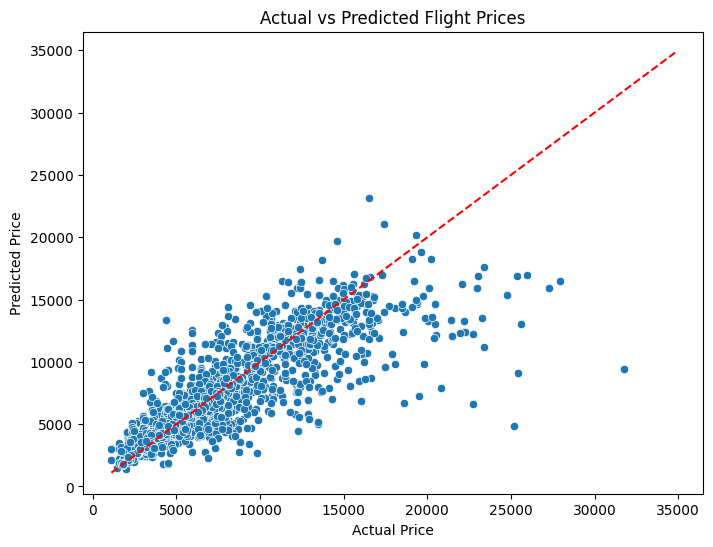

In [16]:
#9 Visualize Predictions

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')  # Diagonal line
plt.show()

In [17]:
#10 Save the Model

import joblib
joblib.dump(model, 'flight_price_model.pkl')

['flight_price_model.pkl']